In [1]:
import requests as rq
from datetime import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List, Tuple, Iterator
from collections import defaultdict

In [2]:
start_time = "2021-07-22%2000:00:00"
end_time = "2021-07-29%2000:00:00"
token = rq.post(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSetToken?DataSet=SGWL.Working%40OW283&StartTime={start_time}&EndTime={end_time}&ExportFormat=csv&Compressed=false&RoundData=False&Unit=306&Timezone=-7").json()["Token"]
raw_csv = rq.get(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSet?DataSet=SGWL.Working%40OW283&StartTime={start_time}&EndTime={end_time}&ExportFormat=csv&Compressed=false&RoundData=False&Unit=306&Timezone=-7&Token={token.replace('+', '%2B').replace('/', r'%2F')}")
reader = list(csv.reader(raw_csv.text.splitlines()))

In [3]:
def clean_and_process(stamp: str, value: str, code: str):
    try:
        if int(code) < 0:
            return False
    except ValueError:
        return False
    if stamp[5:10] == "02-29": # janky hack, mate!
        return False # 😭
    return (
        datetime.fromisoformat(stamp + '-07:00'),
        -float(value)
    )
cleaned = np.transpose(tuple(filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), reader))))

In [4]:
def year_splitter(days: Iterator[Tuple[datetime, float]]) -> defaultdict[int, List[Tuple[datetime, float]]]:
    years = defaultdict(lambda: [])
    for day in days:
        years[day[0].year].append(day)
    return years
    
def unify_year(dates: List[Tuple[datetime, float]]):
    for date in dates:
        if date[0].year != 2021:
            date = (date[0].replace(year=2021), date[1])
    return dates

with open("data/dataset.csv") as data:
    parsed = filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), csv.reader(data)))
    split = year_splitter(parsed)
    years = map(lambda x: np.transpose(unify_year(x)), split.values())

ValueError: I/O operation on closed file.

NameError: name 'years' is not defined

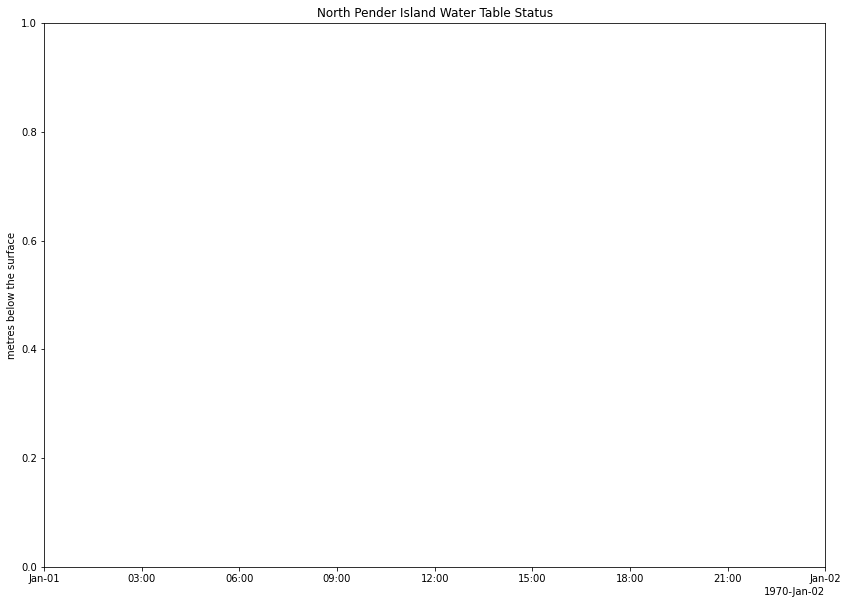

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

ax.set_ylabel("metres below the surface")
ax.set_title("North Pender Island Water Table Status")

locator = mdates.AutoDateLocator(minticks=3, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

year_plots = []

for year in years:
    year_plots.append(ax.plot(year[0], year[1]))